## Data sources

In order to validate the claims from [this](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P) article, I pulled price data from FRED (which sources data from the BLS) and adjusted it using the CPI. Data sources are here:

- [Poultry](https://fred.stlouisfed.org/series/APU0000706111)
- [Pork](https://fred.stlouisfed.org/series/APU0000FD3101)
- [Beef](https://fred.stlouisfed.org/series/APU0000703112)

poultry -.62
pork -.12
beef +.63

The chart below shows how the average price of 3 different types of meats has changed over time. However, these are nominal dollars, not real dollars. To adjust for the change in purchasing power of a dollar, I'll use the CPI to adjust the prices.

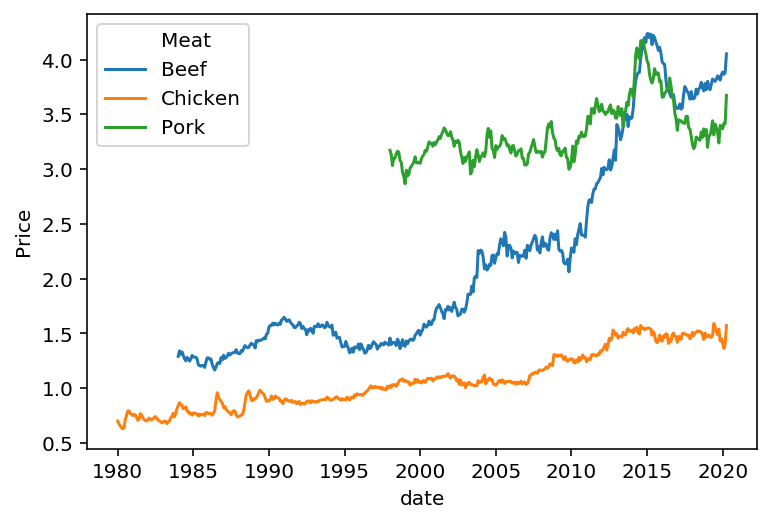

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from IPython.core.display import HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run ./helpers.ipynb

cpi = get_cpi()
pcs = get_prices()

sns.lineplot(x='date', y='price', hue='Meat', data=pcs);
plt.ylabel('Price');

In [20]:
CURRENT_CPI = cpi.loc[cpi.date == cpi.date.max(), 'cpi'].values[0]

(
    pcs.merge(cpi, how='left', on=['date'])
    .assign(cur_price = lambda x: get_adjust(past_cpi=x.cpi,
                                             current_cpi = CURRENT_CPI,
                                             past_price = x.price))
    .pipe(lambda x: sns.lineplot(x='date', y='cur_price', hue='Meat', data=x))
);

In [ ]:
#HTML(df.to_html().replace('border="1"','border="0"'))